<a href="https://colab.research.google.com/github/mvenouziou/Project_Style_Transfer/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer Model

This app takes a 'content' image and adapts it with texture elements from a second image. 

- Try my web app implementation at www.communicatemission.com/ml-projects#style_transfer. 


*The image model has been coded utilizing techniques from DeepLearning.ai specialization on Coursera (www.coursera.org/learn/nlp-sequence-models) and the Tensorflow style transfer documentation (www.tensorflow.org/tutorials/generative/style_transfer). The web app is built on the Anvil platform.*

In [ ]:
#### REQUIRED IMPORTS ####

# ML design
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
import tensorflow_probability as tfp

# data handling
import numpy as np
from PIL import Image

# visualization
import matplotlib.pyplot as plt 
%matplotlib inline
import IPython.display as display

# file management
import pickle

##### GLOBAL VARIABLES
File directories and hyperparameters

In [ ]:
# GLOBAL VARIABLES - Parameters

SIZE = (224, 224)
CONTENT_WEIGHT = 10000
STYLE_WEIGHT = 1
LAYERS_WEIGHTS = {#1: 0.2,  # choose style layers & weighting to use
                  #4: 0.2,
                  7: 0.2,
                  12: 0.15,
                 # 17: 0.2,
                  #18: 0.2,
                  }

In [ ]:
# GLOBAL VARIABLES - File Structure

# 3rd Party Integrations (enabled / disabled)
USE_ANVIL = False
USE_GOOGLE_DRIVE = False

# File Directory Structure
# images datasets (Github)
IMAGES_DIR = \
    'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/'

# saved models (Google Drive)
GDRIVE_DIR = '/content/gdrive/'
FILEPATH = GDRIVE_DIR + 'MyDrive/Colab_Notebooks/models/style_transfer/'
CHECKPOINT_DIR = FILEPATH + 'checkpoints/'
CACHE_DIR = FILEPATH + 'cache/'
GENERATED_IMAGES_DIR = FILEPATH + 'generated_images/'

# mount google drive:
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount(GDRIVE_DIR)

# connect to Anvil web app server
if USE_ANVIL:
    # Anvil Web App server
    !pip install anvil-uplink
    import anvil.server
    anvil.server.connect("UMLOKET2MENJ234VPMB26WCO-FXYOFTHT5SD2KYNR")
    import anvil.media

In [ ]:
# GLOBAL VARIABLES - Images

# set default images
DEFAULT_CONTENT_IMAGE_NAME = 'protest'
DEFAULT_STYLE_IMAGE_NAME = 'flowers'
DEFAULT_TRANSFER_MODEL_NAME = 'vgg'

# available images (free license images sourced from unsplash.com)
IMAGE_OPTIONS = \
    {'protest': 'josh-hild-RD0BXCGemEY-unsplash.jpg',
    'statue_of_liberty': 'brandon-mowinkel-UGi_Ng56FRI-unsplash.jpg',
    'two_color_straight': 'autumn-studio-PaM7SD5wM6g-unsplash.jpg',
    'flowers': 'aida-batres-_QxzSVWesm0-unsplash.jpg',
    'colors_wild': 'pawel-czerwinski-g2Zf3hJyYAc-unsplash.jpg',
    'flag': 'lucas-sankey-gdQ_az6CSPo-unsplash.jpg',
     }

# available transfer learning base models
TRANSFER_MODEL_OPTIONS = \
    {'vgg': tf.keras.applications.VGG19, # ImageNet VGG Very Deep 19
    }

#### Load pretrained VGG net as base model for transfer learning

In [ ]:
# load pre-trained model for extracting style layers
def load_base_model(transfer_model_name, transfer_model_options):
    
    """
    ##### parameters set for using VGG
    To do: add more model options
    """
    # select model
    model = transfer_model_options[transfer_model_name]

    # load model
    source_model = model(include_top=False, 
                         weights='imagenet', 
                         input_tensor=None, 
                         input_shape=None, 
                         pooling=None, 
                         classes=1000, 
                         classifier_activation='softmax')
   
    # lock model for transfer learning
    source_model.trainable = False  

    return source_model


def load_image_from_URL(image_name, 
                        images_directory=IMAGES_DIR,
                        image_options=IMAGE_OPTIONS):
    
    # choose from saved options
    image_file = image_options[image_name]
    image = tf.keras.utils.get_file(image_file, images_directory + image_file)

    return image

#### Image Preprocessing

In [ ]:
# load and prepare images for model
def prepare_images(image, size):
    """ converts images to tensors and standardizes for model """

    # load images as PIL and resize
    image = tf.keras.preprocessing.image.load_img(image, target_size=size)

    # convert to array and standardize
    image = tf.keras.preprocessing.image.img_to_array(image)/255.

    # add dimension for batch size: (1, height, width, channels)
    # and convert to tensor
    image_tensor = tf.expand_dims(image, axis=0)

    return image_tensor


def initialize_generated_image(input_image, noise_rate):
    """ creates noisy version of content image """

    # define random noise
    noise = tf.random.uniform(shape=input_image.shape, minval=-20, maxval=20)
    
    # update image
    image = noise * noise_rate + input_image * (1 - noise_rate)

    # convert to tensor
    image_tensor = tf.convert_to_tensor(image)
    
    return image_tensor

#### Custom Cost Functions
Measures the differences between generated image and 1) content image and 2) style layers from style image.

In [ ]:
### Cost Functions - Image Content
# this cost component helps generated image resemble the content image
# it is only applied to the final generated image
def content_cost(image_activations, generated_activations, content_layer):

    # load content tensors
    image_activ = image_activations[content_layer]
    generated_activ = generated_activations[content_layer]

    # define scale factor for this cost component
    height = image_activ.shape[-3]
    width = image_activ.shape[-2]
    num_channels = image_activ.shape[-1]
    scale_factor = 1 / (4 * height * width * num_channels)

    # compute cost as distance between source image and generated image
    distance = image_activ - generated_activ
    cost = scale_factor * tf.norm(tensor=distance, ord='euclidean')

    return cost

In [ ]:
### Cost Functions - Gradient Content (represents image style)
# this cost component helps generated image resemble the style image's texture
# it is applied to interior image layer activation(s)

# measures the difference in gradients between image and generated images
def gram_matrix(image):
    """
    Computes Gram Matrix
    Parameter: tensors of shape (px_width, px_height, channels)
    """

    num_channels = image.shape[-1]
    image = tf.reshape(image, [-1, num_channels])
    gram = tf.linalg.matmul(image, image, transpose_a=True, transpose_b=False)

    return gram


# adds up gram_matrix across chosen layers
def style_cost(style_activations, generated_activations, weights):

    # initialize cost
    cost = 0

    for layer in weights.keys():

        # get content data
        style_activ = style_activations[layer]
        generated_activ = generated_activations[layer]
        weight = weights[layer]

        # compute scale factor (scale factor used in deeplearning.ai specialization)
        height = style_activ.shape[-3]
        width = style_activ.shape[-2]
        num_channels = style_activ.shape[-1]
        scale_factor = 1 / (4 * (height**2) * (width**2) * (num_channels**2))

       # compute distance between style and generated gradients
        gram_style = gram_matrix(style_activ)
        gram_generated = gram_matrix(generated_activ)
        distance = gram_style - gram_generated

       # compute cost
        cost += weight * scale_factor * tf.norm(distance, ord=2)**2

    return cost

#### Forward Pass Definition

In [ ]:
def learn_activations(input_tensor, orig_model, layer_nums):
    """
    Conducts forward pass of given model and stores activations
    indicated by layers list.
    """

    # initialize activations container
    activations_computed = dict()

    # forward passes through selected layers
    x = input_tensor

    for k in range(len(layer_nums)):
        if k==0:
            start_layer=0
        else:
            start_layer = layer_nums[k-1] + 1
            
        end_layer = layer_nums[k]
        
        # travel through model to next desired activation layer
        for layer_number in range(start_layer, end_layer+1):
            x = orig_model.layers[layer_number](x)
        
        # record activation
        activations_computed[end_layer] = x

    # ensure final layer output is included
    final_layer_num = len(orig_model.layers) - 1
    if final_layer_num not in activations_computed:

        # travel through model to next desired activation layer
        start_layer = np.max(layer_nums) + 1
        end_layer = final_layer_num
        for layer_number in range(start_layer, end_layer+1):
            x = orig_model.layers[layer_number](x)
        
        # record activation
        activations_computed[end_layer] = x

    return activations_computed

In [ ]:
def train_generated_image(init_generated_image, image_activations, 
                          style_activations, cnn_model, 
                          content_weight, style_weight, 
                          num_iterations, learning_rate, 
                          layers_dict=LAYERS_WEIGHTS, 
                          checkpoint_dir=CHECKPOINT_DIR,
                          generated_images_dir=GENERATED_IMAGES_DIR):

    # show initial (noisy) image
    def view_tensor_as_image(learned_image_tensor, show=True):
        
        # rescale image to take on RGB values between 0 and 255
        learned_image = tf.convert_to_tensor(learned_image_tensor * 255)
        
        # remove dummy dimension (representing batch_size component)
        learned_image = tf.squeeze(learned_image)

        # show image
        if show:
            display.clear_output(wait=True)
            display.display(convert_tensor_to_image(learned_image, False))
                
        return learned_image

    print('Original image:\n')
    view_tensor_as_image(init_generated_image, show=True)

    # initialize containers
    computed_images_dict = dict()

    # get parameters
    layers = list(layers_dict.keys())
    content_layer = len(cnn_model.layers) - 1

    # initialize trainable variables (generated image)
    learned_im = tf.Variable(init_generated_image)

    # set optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                         beta_1=0.9, 
                                         beta_2=0.999, epsilon=1e-1, 
                                         amsgrad=False, name='Adam')
    
    # (loss function defined within training loop)

    # training loop
    for iteration in range(num_iterations):

        # forward pass
        # set gradient tracking
        with tf.GradientTape() as tape:
            tape.watch(learned_im)  # optimizing for the learned image

            # reset loss function with new variable values
            # (with learned image being treated as a global variable)
            def loss_function():

                # get activations
                generated_activations = \
                    learn_activations(learned_im, cnn_model, layers)

                # compute loss
                loss = content_weight * content_cost(image_activations, 
                                                     generated_activations, 
                                                     content_layer) + \
                        style_weight * style_cost(style_activations, 
                                                  generated_activations, 
                                                  layers_dict)             
                return loss

        # backward pass
        optimizer.minimize(loss=loss_function, var_list=[learned_im])

        ## (maintain image values between 0 and 1)
        learned_im = tfp.math.clip_by_value_preserve_gradient(
                                      learned_im, 
                                      clip_value_min=0.0, 
                                      clip_value_max=1.0
                                      )
        
        ## enforce tensor being treated as an (updatable) variable object
        learned_im = tf.Variable(learned_im)

        # save progress and give status updates
        save_iter_mark = 100
        show_iter_mark = 1 + save_iter_mark//5

        # report results / save checkpoints
        if iteration % save_iter_mark == 0:
            
            # report status
            print("iteration:", iteration)
            print("loss:", loss_function().numpy())

            # show generated image
            learned_image = view_tensor_as_image(learned_im, show=True)

            # save generated image in checkpoint            
            if USE_GOOGLE_DRIVE:
                
                save_filename = checkpoint_dir + 'learned_im_tensor_' + \
                                '_iter_' + str(iteration) + '.pickle'

                with open(save_filename, 'wb') as handle:
                    pickle.dump(learned_image, handle, 
                                protocol=pickle.HIGHEST_PROTOCOL)

                # save image to dictionary
                computed_images_dict[iteration] = learned_im
    
    # training ends                
    # show results
    print("Completed.")
    print("loss:", loss_function().numpy())

    # convert back to viewable image (tensor)
    learned_image = view_tensor_as_image(learned_im)

    # save result
    if USE_GOOGLE_DRIVE:
        save_filename = generated_images_dir + 'learned_im.jpg'

        tf.keras.preprocessing.image.save_img(save_filename, learned_image)

    return learned_image, computed_images_dict


In [ ]:
def style_transfer(saved_variables, image_content_name, image_style_name, 
                   transfer_model_name, learning_rate,num_iterations,
                   checkpoint_dir=CHECKPOINT_DIR, content_weight=CONTENT_WEIGHT,
                   style_weight=STYLE_WEIGHT):

    print('Note: Generated image may take time to converge)\n' +
       'Use of GPU or low number of iterations highly recommended')

    """
    note: 
    saved_variables = {'activations': activations_dict,
                       'layers_dict': layers_dict,
                       'init_generated_image': init_generated_image,
                       'image_tensors': image_tensors_dict,
                       'transfer_model': transfer_model,
                       }
    """


    # get transfer base model
    transfer_model = saved_variables['transfer_model']
    
    # get prepared images
    image_tensor = saved_variables['image_tensors'][image_content_name]
    style_tensor = saved_variables['image_tensors'][image_style_name]
    init_generated_image = \
        saved_variables['init_generated_image'][image_content_name]
    
    # get CNN layer numbers for transfer
    layers_dict = saved_variables['layers_dict']

    # get activations based on pretrained transfer model
    image_activations = saved_variables['activations'][image_content_name]
    style_activations = saved_variables['activations'][image_style_name]

    # generate new image / train model
    learned_image, computed_images_dict = \
        train_generated_image(init_generated_image=init_generated_image, 
                              image_activations=image_activations, 
                              style_activations=style_activations, 
                              cnn_model=transfer_model, 
                              layers_dict=layers_dict, 
                              content_weight=content_weight, 
                              style_weight=style_weight, 
                              num_iterations=num_iterations,
                              learning_rate=learning_rate,
                              checkpoint_dir=checkpoint_dir
                              )

    return learned_image, computed_images_dict

#### Image viewer

In [ ]:
# Helper filer: converts image from tensor format to viewable format
def convert_tensor_to_image(image_tensor, view=True):
    
    # convert tensor to image
    im_array = image_tensor.numpy()
    image = tf.keras.preprocessing.image.array_to_img(
                    im_array, data_format=None, scale=True, dtype=None)
    # display image
    if view is True:
        plt.imshow(image)

    return image

Preload prepared image / models



In [ ]:
# Preload prepared image / models

def preload_variables(transfer_model_name=DEFAULT_TRANSFER_MODEL_NAME,
                      transfer_model_options=TRANSFER_MODEL_OPTIONS,
                      image_options=IMAGE_OPTIONS,
                      layers_dict=LAYERS_WEIGHTS,
                      noise_rate=.01,
                      size=SIZE):

    # prepare transfer model
    ########### update this section
    for model_name in transfer_model_options:
        transfer_model = load_base_model(model_name, 
                                         transfer_model_options)

    # get layer numbers for activation computations
    layers = list(layers_dict.keys())  

    # initialize containers
    image_tensors_dict = {}
    init_generated_image_dict = {}
    activations_dict = {}

    # process each image
    for image_name in image_options:

        # load and preprocess image to tensor
        image = load_image_from_URL(image_name)
        image_tensor = prepare_images(image, size)
        
        # initialize corresponding generated image
        init_generated_image = \
            initialize_generated_image(image_tensor, noise_rate)

        # get activations
        activations = learn_activations(image_tensor, transfer_model, layers)
        
        # save in dict
        image_tensors_dict[image_name] = image_tensor
        init_generated_image_dict[image_name] = init_generated_image
        activations_dict[image_name] = activations

    # organize outputs
    out = {'activations': activations_dict,
           'layers_dict': layers_dict,
           'init_generated_image': init_generated_image_dict,
           'image_tensors': image_tensors_dict,
           'transfer_model': transfer_model,
           }

    return out

Pre-load Images, Model and Activations

In [ ]:
SAVED_VARIABLES_DICT = preload_variables(
                            transfer_model_name=DEFAULT_TRANSFER_MODEL_NAME,
                            transfer_model_options=TRANSFER_MODEL_OPTIONS,
                            image_options=IMAGE_OPTIONS,
                            noise_rate=.01,
                            size=SIZE)

Final Function for Generating Images

In [ ]:
#@anvil.server.callable
def generate_image(orig_image=DEFAULT_CONTENT_IMAGE_NAME, 
                   style_image=DEFAULT_STYLE_IMAGE_NAME,
                   transfer_model_name=DEFAULT_TRANSFER_MODEL_NAME,
                   learning_rate=.20,
                   num_iterations=3):   

    learned_image, _ = \
        style_transfer(saved_variables=SAVED_VARIABLES_DICT,
                       image_content_name=orig_image, 
                       image_style_name=style_image, 
                       transfer_model_name=transfer_model_name,
                       learning_rate=learning_rate,
                       num_iterations=num_iterations)
    
    save_filename = 'temp.jpg'    
    tf.keras.preprocessing.image.save_img(save_filename, learned_image)

    if USE_ANVIL:
        im_file = anvil.media.from_file("temp.jpg")
        
    else:
        im_file = convert_tensor_to_image(learned_image, view=True)
    
    return im_file

if USE_ANVIL:
    anvil.server.wait_forever()

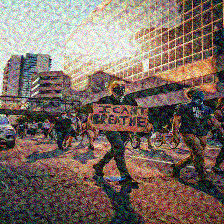

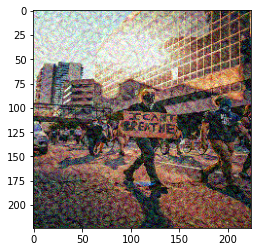

In [ ]:
# Run program
orig_image = 'protest'
style_image = 'flowers'

temp_image = generate_image(orig_image, 
                            style_image,
                            learning_rate=.25,
                            num_iterations=3)
